In [1]:
# Refactoring tips : https://pytorch.org/tutorials/beginner/nn_tutorial.html
# Module forward hook : https://blog.paperspace.com/pytorch-hooks-gradient-clipping-debugging/
# Module, Sequential, and organizing better : https://github.com/FrancescoSaverioZuppichini/Pytorch-how-and-when-to-use-Module-Sequential-ModuleList-and-ModuleDict/blob/master/README.md
# writing your own optimizer http://mcneela.github.io/machine_learning/2019/09/03/Writing-Your-Own-Optimizers-In-Pytorch.html
# torch tensor quick start operatiosn https://jhui.github.io/2018/02/09/PyTorch-Basic-operations/
# SGD optimizer codein pytorch https://pytorch.org/docs/stable/_modules/torch/optim/sgd.html#SGD.step
# Understanding torch nn Parameter https://stackoverflow.com/questions/50935345/understanding-torch-nn-parameter

# Not used:
# https://medium.com/pytorch/accelerate-your-hyperparameter-optimization-with-pytorchs-ecosystem-tools-bc17001b9a49


In [2]:
import os
import torch
from torch import nn
import numpy as np

from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

import matplotlib.pyplot as plt
#%matplotlib widget

# Dataset

In [3]:
class XORDataset(Dataset):
    """XOR dataset."""

    def __init__(self, num_samples = 200):
        """
        Args:
            num_samples: number of samples to generate
        """

        self.num_samples = num_samples
        self.X = np.random.randint(0,high=2, size=num_samples*2).reshape((num_samples, 2)).astype(np.float32)
        self.y = np.logical_xor(self.X[:,0], self.X[:,1]).reshape((num_samples,1)).astype(np.float32)

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        #sample = {'X': self.X[idx], 'y': self.y[idx]}
        sample = (self.X[idx], self.y[idx])

        return sample

# Dataloaders, get_data

In [4]:
def get_data(batch_size, num_samples):

    datasets = {
        'train' : XORDataset(num_samples),
        'valid' : XORDataset(50),
    }
    loaders = {
    'train' : torch.utils.data.DataLoader(datasets['train'],  
                                          batch_size=batch_size, 
                                          shuffle=True,
                                          num_workers=1),
    'valid' : torch.utils.data.DataLoader(datasets['valid'], 
                                          batch_size=10, 
                                          shuffle=True,
                                          num_workers=1),
    }
    return datasets, loaders
    

# Net model
## class XORnet

In [5]:
class XORnet(nn.Module):

    def __init__(self):
        super(XORnet, self).__init__()

        self.fc1=nn.Linear(2, 2)
        self.sig1=nn.Sigmoid()
        self.fc2=nn.Linear(2, 1)
        self.sig2=nn.Sigmoid()
        
        self.activations=[0 for i in range(3)] # 3 "layers" : input/hidden/output

        # custom weight initialization

        for layer in [self.fc1, self.fc2]:
            nn.init.normal_(layer.weight)


    def forward(self, x):
        '''Forward pass'''
        
        x2 = self.fc1(x)
        x2 = self.sig1(x2)
        x3 = self.fc2(x2)
        x3 = self.sig2(x3)
        self.store_activations(x, x2, x3)
        return x3

    def store_activations(self, x, x2, x3):
        self.activations[0] = x
        self.activations[1] = x2
        self.activations[2] = x3

In [6]:
# to do : determine learning rate by grid search
'''To make comparisons easier, we use the
same learning rate η for FF+FB and FF, determined by grid search. 
We average 10 runs, taking g = 0.7 and η = 0.025 for both networks. The number of
epochs is capped to 300 epochs. With these constraints, η is optimized (by grid search) for the smallest
number of epochs of the two networks that reached 100% training accuracy in 10 runs.'''

'To make comparisons easier, we use the\nsame learning rate η for FF+FB and FF, determined by grid search. \nWe average 10 runs, taking g = 0.7 and η = 0.025 for both networks. The number of\nepochs is capped to 300 epochs. With these constraints, η is optimized (by grid search) for the smallest\nnumber of epochs of the two networks that reached 100% training accuracy in 10 runs.'

# class statsLogger

In [7]:
from datetime import date, datetime
import pathlib

class statsLogger():
    def __init__(self, learner=None):
        self.accuracies=[]   # accuracy for each epoch
        self.losses=[]
        self.epochs=0
        self.minibatches=0
        self.samples=0
        self.all_minibatches_accuracies=[]  # accuracies for all minibatches in all epochs
        self.all_minibatches_losses=[]  # accuracies for all minibatches in all epochs
        self.learner = learner
        self.bs=None
        self.run_name=None

    def getRunName(self):
        if self.run_name == None:
            today = date.today()
            now=datetime.now().strftime("%H%M%S")
            run_name=f'{today}-{now}-'

            learner=self.learner

            if learner is not None:
                run_name+=f'{learner.model.__class__.__name__}-{learner.opt.__class__.__name__}-{learner.lr}-bs{self.bs}'
            self.run_name = run_name

        return self.run_name
        

    def startEpoch(self):
        self.epoch_total_samples=0
        self.epoch_total_minibatches=0
        self.epoch_correct_samples=0
        self.minibatch_losses=[]  # losses for all minibatches in the epoch
        

    def getMinibatchStats(self, pred, yb, loss, pref_fn=lambda pred : (pred>0.5).float() ):

        #Accuracy
        predicted = pref_fn(pred)
        minibatch_num_corrects = (predicted == yb).float().sum()
        minibatch_total = pred.shape[0]
        if self.bs == None:
            self.bs = minibatch_total
        self.epoch_total_samples += minibatch_total
        self.epoch_correct_samples += minibatch_num_corrects.item()
        self.minibatch_losses.append(loss.item())
        self.all_minibatches_losses.append(loss.item())
        self.all_minibatches_accuracies.append(100 *  minibatch_num_corrects.item() / minibatch_total)
        self.minibatches+=1
        self.epoch_total_minibatches+=1

    def endEpoch(self):
        self.losses.append(np.array(self.minibatch_losses).mean())
        epoch_accuracy = 100 * self.epoch_correct_samples / self.epoch_total_samples
        self.accuracies.append(epoch_accuracy)
        self.epochs+=1
        self.samples+=self.epoch_total_samples
        return epoch_accuracy

    def save(self, train_or_val: str, target_accuracy):

        learner = self.learner
        if learner is not None:
            filename=f'{train_or_val}-{learner.model.__class__.__name__}-{learner.opt.__class__.__name__}-lr{learner.lr}-bs{self.bs}.csv'
        else:
            filename=f'{train_or_val}-bs{self.bs}.csv'
          
        run_name = self.getRunName()
        epoch_with_target_accuracy_or_last_epoch = next((i+1 for i, acc in enumerate(self.accuracies) if acc >= 100), len(self.accuracies))
        print(f'Target accuracy of {target_accuracy} achieved at epoch {epoch_with_target_accuracy_or_last_epoch} : \
             loss {self.losses[epoch_with_target_accuracy_or_last_epoch-1]}, accuracy {self.accuracies[epoch_with_target_accuracy_or_last_epoch-1]}')
        info = {
            'run_name': [run_name],
            'target_epoch_accuracy': [target_accuracy],
            'epoch': [epoch_with_target_accuracy_or_last_epoch], 
            'epoch_loss': [self.losses[epoch_with_target_accuracy_or_last_epoch-1]],
            'epoch_accuracy': [self.accuracies[epoch_with_target_accuracy_or_last_epoch-1]]
        }

        file = pathlib.Path(filename)
        print(f'Saving epoch to reach target accuracy to {filename}')

        if file.exists ():

            df = pd.read_csv(filename)
            df2 = pd.DataFrame(info)
            result = pd.concat([df, df2])
            result.to_csv(filename, sep=',', index=None)
        else:

            df = pd.DataFrame(info)
            df.to_csv(filename, sep=',', index=None)
    

# Information Theory measures

## class ActivationsCollector

In [8]:
import pandas as pd
from datetime import date, datetime

class activationsCollector():
    def __init__(self, g):
        self.g = g
        # 5 because 2 input, 2 hidden layer neurons ad 1 output in perceptron ==> 5 activations to store
        self.neurons={}
        self.binNeurons={}
        self.targets=[]
        self.num_layers=0
        self.num_neurons_per_layer=[]
        self.bs=0

    def collect(self, model, yb):

        self.bs=yb.size()[0]         # the first dim of the activation tensor or target tensor is the number of samples in minibatch
        bs=self.bs

        # storing the targets
        self.targets.extend([yb[i].item() for i in range(bs)])

        activations=model.activations

        # Layer details initializations on first time use
        if self.num_layers==0:
            self.num_layers=len(activations)
            for l in range(self.num_layers):
                self.num_neurons_per_layer.append(activations[l].size()[1])  # the second dimensions of the activations in a layer is the number of neurons in that layer

        # collecting activations browing through the whole net model    
        for l in range(self.num_layers):
            # self.num_neurons_per_layer.append(activations[l].size()[1])

            #for neuron in range(activations[l].size()[1]): 
            for neuron in range(self.num_neurons_per_layer[l]): 

                neuron_name=f'{l}-{neuron}'
                if (neuron_name not in self.neurons):
                    self.neurons[neuron_name]=[]
                    self.binNeurons[neuron_name]=[]

                self.neurons[neuron_name].extend([activations[l][i, neuron].item() for i in range(bs)])
                self.binNeurons[neuron_name].extend([int(activations[l][i, neuron].item() > self.g) for i in range(bs)])

                #if neuron_name=='1-1':
                #print(f'Neuron {neuron_name}:')
                #print('activation:', [activations[l][i, neuron].item() for i in range(bs)])
                #print('discretized:', [int(activations[l][i, neuron].item() > self.g) for i in range(bs)])

    def save(self, run_name):

        # today = date.today()
        # now=datetime.now().strftime("%H%M%S")
        # filename=f'{today}-{now}-'

        # if learner is not None:
        #     filename+=f'{learner.model.__class__.__name__}-{learner.opt.__class__.__name__}-{learner.lr}-bs{self.bs}-'
        filename=f'{run_name}-'

        name_neurons = filename + 'neurons-act.csv'
        name_bin_neurons = filename + f'thres{self.g}-bin-neurons-act.csv'
        df_neuron = pd.DataFrame(self.neurons)
        df_bin_neurons = pd.DataFrame(self.binNeurons)

        df_neuron.to_csv(name_neurons, sep=',', index=False)
        df_bin_neurons.to_csv(name_bin_neurons, sep=',', index=False)



## te calculator class

In [9]:
from jpype import startJVM, getDefaultJVMPath, JArray, JDouble, JInt, JPackage, shutdownJVM, isJVMStarted

javaIntList = lambda l : JArray(JInt, 1)(l)
javaDoubleList = lambda l : JArray(JDouble, 1)(l)
# import sys 
# Our python data file readers are a bit of a hack, python users will do better on this:
# sys.path.append("/home/jovyan/notebooks/jidt/demos/python")

# do we make the assumption that the process is stationary when calculating TE?
# what is the history length that we can consider ?

class teCalculator():
    def __init__(self, model, past, bs, calculator_params):
        self.past=past
        self.bs=bs
        self.model=model
        self.calculator_params=calculator_params

        self.__startJVM()

        self.teHistory={}
        self.teHistoryLocal={}
        self.miHistory={}
        self.miHistoryLocal={}
        self.tekHistory={}
        self.tekHistoryLocal={}

    def save(self, run_name):

        # today = date.today()
        # now=datetime.now().strftime("%H%M%S")
        # filename=f'{today}-{now}-'

        # if learner is not None:
        #     filename+=f'{learner.model.__class__.__name__}-{learner.opt.__class__.__name__}-{learner.lr}-bs{self.bs}-'
        filename=f'{run_name}-'

        name_te = filename + 'interlayer-avgTE.csv'
        name_mi = filename + 'interlayer-avgMI.csv'
        name_tek = filename + 'interlayer-avgTEK.csv'
        df_te = pd.DataFrame(self.teHistory)
        df_mi = pd.DataFrame(self.miHistory)
        df_tek = pd.DataFrame(self.tekHistory)

        df_te.to_csv(name_te, sep=',', index=False)
        df_mi.to_csv(name_mi, sep=',', index=False)
        df_tek.to_csv(name_tek, sep=',', index=False)
        

    def __startJVM(self):
        # Add JIDT jar library to the path
        jarLocation = "/home/jovyan/notebooks/jidt/infodynamics.jar"
        # Start the JVM (add the "-Xmx" option with say 1024M if you get crashes due to not enough memory space)
        if (not isJVMStarted()):
            startJVM(getDefaultJVMPath(), "-ea", "-Djava.class.path=" + jarLocation)
    
    def __setupTECalculator(self, target_history, source_history):
        calcClass = JPackage("infodynamics.measures.discrete").TransferEntropyCalculatorDiscrete
        base=2
        k_history=target_history
        k_tau=1
        i_history=source_history
        i_tau=1
        delay=1
        calc = calcClass(base, k_history, k_tau, i_history, i_tau, delay)
        calc.initialise()

        return calc

    def __setupTEKraskovCalculator(self):
        calcClass = JPackage("infodynamics.measures.continuous.kraskov").TransferEntropyCalculatorKraskov
        calc = calcClass()
        # 2. Set any properties to non-default values:
        calc.setProperty("DELAY", "0")
        # 3. Initialise the calculator for (re-)use:
        calc.initialise()

        return calc

    def __setupMICalculator(self):
        
        # 1. Construct the calculator:
        calcClass = JPackage("infodynamics.measures.discrete").MutualInformationCalculatorDiscrete
        base=2
        time_difference=0
        calc = calcClass(base, base, time_difference)
        # 2. No other properties to set for discrete calculators.
        # 3. Initialise the calculator for (re-)use:
        calc.initialise()
        return calc

    def __extractTimeSeries(self, collector, neuron_i, neuron_j, past=0, binarized=True):

        source_layer, i = neuron_i
        target_layer, j = neuron_j

        if binarized==True:
            neurons = collector.binNeurons
        else:
            neurons = collector.neurons

        if past == 0:
            # take all we got to calculate time series
            source = neurons[f'{source_layer}-{i}']
            target = neurons[f'{target_layer}-{j}']
        else:
            # consider only the nearby "past"
            source = neurons[f'{source_layer}-{i}'][-past:]
            target = neurons[f'{target_layer}-{j}'][-past:]

        return source, target

    def calculateMeasureBetweenNeurons(self, collector, neuron_i, neuron_j, past, calc_setup_fn, calc_name='discrete'):

        # Setup for Kraskov TE - Need to use the non binarized neuron output and also not calculate bias,
        # because Kraskov is already bias corrected

        bias = True
        binarized = True
        if calc_name == 'kraskov':
            bias=False
            binarized=False
        
        # Extracting time series out of neurons activations stored in collector

        source, target = self.__extractTimeSeries(collector, neuron_i, neuron_j, self.past, binarized)

        if binarized == True:
            source = javaIntList(source)
            target = javaIntList(target)
        else:
            source = javaDoubleList(source)
            target = javaDoubleList(target)

        # set up calculator
        calc=calc_setup_fn()

        # 4. Supply the sample data:
    
        if calc_name == 'kraskov':
            calc.setObservations(source, target)
            result=float(calc.computeAverageLocalOfObservations())
            local_results=[]
        else:
            calc.addObservations(source, target)
            bias = calc.computeSignificance().getMeanOfDistribution()
            result=float(calc.computeAverageLocalOfObservations()) - float(bias)
            # to do if I use local_results - add bias
            local_results = calc.computeLocalFromPreviousObservations(source, target)


        return result, local_results

    def __getNeuronPairName(self, neuron_i, neuron_j):
        source_layer, i = neuron_i
        target_layer, j = neuron_j
        pair_name=f'{source_layer}-{i}-{target_layer}-{j}'
        return pair_name

    def __saveMeasure(self, pair_name, history, historyLocals, result, resultLocals):

        if (pair_name not in history):
            history[pair_name]=[]
            historyLocals[pair_name]=[]

        history[pair_name].append(result)
        historyLocals[pair_name].extend(resultLocals)

    def getLastValueInHistory(self, history, neuron_i, neuron_j):
        pair_name = self.__getNeuronPairName(neuron_i, neuron_j)
        if pair_name in history and len(history[pair_name]) > 0:
            return history[pair_name][-1:][0]
        else:
            return 0
    
    def getMeasuresForLayer(self, collector, source_layer, target_layer):
        
        num_sources=collector.num_neurons_per_layer[source_layer]
        num_targets=collector.num_neurons_per_layer[target_layer]

        for i in range(num_sources):
            for j in range(num_targets):

                neuron_i = (source_layer, i)
                neuron_j = (target_layer, j)
                pair_name = self.__getNeuronPairName(neuron_i, neuron_j)

                # Calculate transfer entropy between neurons

                calc_setup_fn = lambda : self.__setupTECalculator(**self.calculator_params['te'])  
                resultTE, local_resultsTE = self.calculateMeasureBetweenNeurons(collector, neuron_i, neuron_j, self.past, calc_setup_fn)

                # Save average value and local values for each batch size

                self.__saveMeasure(pair_name, self.teHistory, self.teHistoryLocal, resultTE, local_resultsTE[-self.bs:])

                # Calculate MI between neurons

                calc_setup_fn = lambda : self.__setupMICalculator()  
                resultMI, local_resultsMI = self.calculateMeasureBetweenNeurons(collector, neuron_i, neuron_j, self.past, calc_setup_fn)

                # Save average value and local values for each batch size

                self.__saveMeasure(pair_name, self.miHistory, self.miHistoryLocal, resultMI, local_resultsMI[-self.bs:])

                # Calculate TE Using non binarized values (!!! in nats)

                calc_setup_fn = lambda : self.__setupTEKraskovCalculator()  
                resultTEK, local_resultsTEK = \
                    self.calculateMeasureBetweenNeurons(collector, neuron_i, neuron_j, self.past, calc_setup_fn, calc_name='kraskov')

                # Save average value and local values for each batch size

                self.__saveMeasure(pair_name, self.tekHistory, self.tekHistoryLocal, resultTEK, local_resultsTEK[-self.bs:])
                
    def calculateTE(self, collector):
        ''' Calculate TE between all neurons from previous layer, 
        the sources, and saves the minibatch values in a history list
        Note: the layer 0 is the input layer, i.e. it contains the input data

        Parameters:
            layer_num (int): layer containing the targets for the transfer entropy calculation. Needs to be >0 (0=input layer)
            collector (activationsCollector): class that collects the activations of the model neurons and their discretized values
            past (int): how far back in the time series do we look to calculate TE. Only the last "past" values of the time series
            are given '''


        num_layers=collector.num_layers

        for target_layer in range(1, num_layers):
           self.getMeasuresForLayer(collector, target_layer-1, target_layer) 

         


## class TeParameters

In [10]:

class TeParameters:

    """Store the last calculated transfer entropies for each layer weights"""

    def __init__(self, model):
        self.te_params = self.__setupTEParameters(model)  #list of tensor same shape and order as model weights that will contain the corresponding te

    def __iter__(self):
        yield self.te_params

    def __call__(self):
        return self.te_params

    def update(self, model, calculator):
        '''Update the tensors containing the te values with the latest TE calculation value'''

        layer = 1
        for i, (name, parameter) in enumerate(model.named_parameters()):
            # this makes it specifc to a Linear module (the parameters containing the weights are called 'weight')
            if 'weight' in name:
                # this makes it specific to a "flat" network (input = 1d) i think
                for src_num_i in range(parameter.size()[1]-1):
                    for target_num_j in range(parameter.size()[0]-1):
                        neuron_i = (layer-1, src_num_i)
                        neuron_j = (layer, target_num_j)
                        # Note: we could update to calculate the value of te between neurons here instead of taking from history
                        self.te_params[i][src_num_i][target_num_j] = calculator.getLastValueInHistory(calculator.teHistory, neuron_i, neuron_j)

                #print(f'Updated TE for parameter {i} with name {name}: TE =  {self.te_params[i]}')
                layer=layer+1
            else:
                self.te_params[i]=None

    def __setupTEParameters(self, model):
        ''' Initialize tensors of same size as model weights (not including bias) to contain the transfer entropy'''

        te_params = []
        for name, parameter in model.named_parameters():
            if 'weight' in name:
                te_param = torch.zeros_like(parameter, requires_grad=False)           
                te_params.append(te_param)
            else:
                te_params.append(None)
        return te_params

In [11]:
#---------------------------------------------------------
# Test Snippet for TEParameters
#---------------------------------------------------------


model=XORnet()
param = TeParameters(model)
calc_params = {
    'te': {
        'source_history': 1,
        'target_history': 1
    }
}
param.update(model, teCalculator(model, 40, 40, calc_params))
for p in param:
    print(p)

[tensor([[0., 0.],
        [0., 0.]]), None, tensor([[0., 0.]]), None]


# Optimizer

http://mcneela.github.io/machine_learning/2019/09/03/Writing-Your-Own-Optimizers-In-Pytorch.html     
https://pytorch.org/docs/stable/_modules/torch/optim/sgd.html#SGD.step   
https://github.com/pytorch/pytorch/blob/master/torch/optim/_functional.py    


## F.sgd2

In [12]:
# Copied from https://github.com/pytorch/pytorch/blob/master/torch/optim/sgd.py and updated 

from torch import Tensor
from typing import List, Optional

def sgd2(params: List[Tensor],
        d_p_list: List[Tensor],
        momentum_buffer_list: List[Optional[Tensor]],
        *,
        weight_decay: float,
        momentum: float,    
        lr: float,
        dampening: float,
        nesterov: bool,
        te_params: List[Tensor]):

    for i, param in enumerate(params):

        d_p = d_p_list[i]
        if weight_decay != 0:
            d_p = d_p.add(param, alpha=weight_decay)

        if momentum != 0:
            buf = momentum_buffer_list[i]

            if buf is None:
                buf = torch.clone(d_p).detach()
                momentum_buffer_list[i] = buf
            else:
                buf.mul_(momentum).add_(d_p, alpha=1 - dampening)

            if nesterov:
                d_p = d_p.add(buf, alpha=momentum)
            else:
                d_p = buf

        #print('param before descent:', param)
        if te_params is not None:
            te_param = te_params[i]
            if te_param is not None:
                #print('corresponding te_param:', te_param)
                param.add_(d_p * (1 - te_param), alpha=-lr)
            else:
                param.add_(d_p, alpha=-lr)
        else:     
            param.add_(d_p, alpha=-lr)
        #print('param after descent:', param)

## SGD2 Optimizer

In [13]:
# https://pytorch.org/docs/stable/_modules/torch/optim/sgd.html#SGD.step
from torch.optim import Optimizer
from torch.optim import _functional as F

class SGD2(Optimizer):
    '''
    Implement backpropagation algorithm with a twist
    Using inter-neuron transfer entropy to change the weight update
    Wl:= Wl − η∆l(1 − tel)
    '''
    def __init__(self, params, te_params, lr=1e-3,momentum=0, dampening=0,
                 weight_decay=0, nesterov=False):

        if lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if weight_decay < 0.0:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))
        if momentum < 0.0:
            raise ValueError("Invalid momentum value: {}".format(momentum))

        defaults = dict(te_params = te_params, lr=lr, momentum=momentum, dampening=dampening,
                        weight_decay=weight_decay, nesterov=nesterov)
        if nesterov and (momentum <= 0 or dampening != 0):
            raise ValueError("Nesterov momentum requires a momentum and zero dampening")
        super(SGD2, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(SGD2, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('nesterov', False)


    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step.

        Args:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            params_with_grad = []
            d_p_list = []
            weight_decay = group['weight_decay']
            momentum_buffer_list = []
            momentum = group['momentum']
            dampening = group['dampening']
            nesterov = group['nesterov']
            lr = group['lr']

            te_params=group['te_params']

            for p in group['params']:
                if p.grad is not None:
                    params_with_grad.append(p)
                    d_p_list.append(p.grad)

                    state = self.state[p]

                    if 'momentum_buffer' not in state:
                        momentum_buffer_list.append(None)
                    else:
                        momentum_buffer_list.append(state['momentum_buffer'])

            sgd2(params_with_grad,
                d_p_list,
                momentum_buffer_list,
                weight_decay=weight_decay,
                momentum=momentum,
                lr=lr,
                dampening=dampening,
                nesterov=nesterov,
                te_params=te_params)

            # update momentum_buffers in state
            for p, momentum_buffer in zip(params_with_grad, momentum_buffer_list):
                state = self.state[p]
                state['momentum_buffer'] = momentum_buffer

        return loss

# Learner class

In [14]:
class learner():

    def __init__(self, model, calculator, lr, opt_name, loss_fn=nn.MSELoss(), te_params=None):
        self.model = model
        self.calculator = calculator
        self.lr = lr
        self.loss_fn = loss_fn
        print('learner lr:', lr)
        print('learner te_params:', te_params)
        optimizers = {
            'adam': torch.optim.Adam(model.parameters(), lr = lr) ,
            'SGD': torch.optim.SGD(model.parameters(), lr = lr), 
            'SGD2': SGD2(model.parameters(),te_params , lr = lr)
        }
        self.opt = optimizers[opt_name]

    def get_model(self):
        return self.model, self.opt, self.loss_fn

# Plot/save training stats

## plot per epoch

In [15]:
def plotTraining(loggers: list, learner: learner):
    
    fig, axs= plt.subplots(1, 2, figsize=(18, 6))  
    plt.title('XOR Dataset Opt={}, lr={}, loss_fn={}'
        .format(learner.opt.__class__.__name__, learner.lr, learner.loss_fn.__class__.__name__))

    axs[0].plot(loggers['train'].losses, label='Train loss')
    axs[0].plot(loggers['valid'].losses, label='Valid loss')
    axs[0].set_title('Losses')
    axs[0].set_xlabel('epochs')
    axs[0].set_ylabel('loss')

    axs[1].plot(loggers['train'].accuracies, label='Train accuracy')
    axs[1].plot(loggers['valid'].accuracies, label='Valid accuracy')
    axs[1].set_title('Accuracies')  
    axs[1].set_xlabel('epochs')
    axs[1].set_ylabel('Accuracy')

    plt.legend()
    plt.show()

## plot per minibatch

In [16]:
def plotTrainingPerMiniBatch(loggers: list, learner: learner):
    
    fig, axs= plt.subplots(1, 2, figsize=(18, 6))  
    plt.title('XOR Dataset Opt={}, lr={}, loss_fn={}'
        .format(learner.opt.__class__.__name__, learner.lr, learner.loss_fn.__class__.__name__))

    axs[0].plot(loggers['train'].all_minibatches_losses, label='Minibatch Train loss')
    #axs[0].plot(loggers['valid'].all_minibatches_losses, label='Minibatch Valid loss')
    axs[0].set_title('Losses')
    axs[0].set_xlabel('Minibatches')
    axs[0].set_ylabel('loss')

    axs[1].plot(loggers['train'].all_minibatches_accuracies, label='Minibatch Train accuracy')
    #axs[1].plot(loggers['valid'].all_minibatches_accuracies, label='Minibatch Valid accuracy')
    axs[1].set_title('Accuracies')  
    axs[1].set_xlabel('Minibatches')
    axs[1].set_ylabel('Accuracy')

    plt.legend()
    plt.show()

# fit() function

In [20]:
def fit(learner, loaders, epochs, collector, teCalc, teParams, target_accuracy):

    model, optimizer, loss_fn = learner.get_model()
    trainLogger = statsLogger(learner)
    validLogger = statsLogger(learner)

    for epoch in range(epochs): 

        trainLogger.startEpoch()

        ## training part 
        ##--------------

        model.train()
        for i, (xb, yb) in enumerate(loaders['train']):
            print(f'batch {i} epoch {epoch}')

            optimizer.zero_grad()

            ## 1. forward propagation
            pred = model(xb)

            # activations
            collector.collect(model, yb)
            teCalc.calculateTE(collector)
            
            teParams.update(model, teCalc)
            
            ## 2. loss calculation
            loss = loss_fn(pred, yb)        
            
            ## 3. backward propagation
            loss.backward()
            
            ## 4. weight optimization
            optimizer.step()

            #logger
            trainLogger.getMinibatchStats(pred, yb, loss)

        epoch_accuracy = trainLogger.endEpoch()
        print(f'Epoch {epoch} completed with accuracy {epoch_accuracy}, target accuracy = {target_accuracy}')
        if (epoch_accuracy == target_accuracy):
            print(f'break epoch loop')
            break
            
        ## evaluation part
        ## ---------------

        with torch.no_grad():  #gradients should not evaluate
            model.eval()
            validLogger.startEpoch()
            for xb, yb in loaders['valid']:
                pred = model(xb)
                loss = loss_fn(pred, yb)

                validLogger.getMinibatchStats(pred, yb, loss)

            _ = validLogger.endEpoch()

    return { 'train' : trainLogger, 'valid' : validLogger }

# TRAINING !!! 

In [21]:
def train(lr=0.03, bs=40, num_samples=200, g=0.7, epochs=100, past=40, opt_name='adam', calculator_params={'te':{'target_history':1, 'source_history':1}}):

    model=XORnet()

    activation_collector=activationsCollector(g)
    teCalc=teCalculator(model, past, bs, calculator_params)
    teParams=TeParameters(model)

    #Xorln = learner(model=model, calculator=teCalc, lr=lr, opt_name='SGD2', te_params=teParams())
    Xorln = learner(model=model, calculator=teCalc, lr=lr, opt_name=opt_name, te_params=None)

    loggers = fit(Xorln, loaders, epochs, activation_collector, teCalc, teParams, target_accuracy=100)

    lg=loggers['train']
    print(f'{lg.epochs} epochs completed, epoch minibatches/samples: {lg.epoch_total_minibatches}/{lg.epoch_total_samples}, total minibs/samples:{lg.minibatches}/{lg.samples}')
    plotTraining(loggers, Xorln)
    plotTrainingPerMiniBatch(loggers, Xorln)

    # Saving data

    run_name = lg.getRunName()
    print(f'Saving data for run {run_name}')
    activation_collector.save(run_name)
    teCalc.save(run_name)
    lg.save('Train', 100)

    return activation_collector, teCalc, lg

# java.lang.RuntimeException: java.lang.RuntimeException: Base and history combination too large

In [25]:
lr = 0.03   #0.03, 0.025 in paper
bs = 40
num_samples = 200
datasets, loaders = get_data(bs, num_samples)
g=0.7
epochs=300 #100
opt_name = 'SGD'

past = bs

calculator_params = {
    'te': {
        'target_history': 1,
        'source_history': 1
    }
}

# activation_collector, teCalc, lg = train(lr=lr, bs=bs, num_samples=num_samples, g=g, epochs=epochs, past=bs, calculator_params=calculator_params)

for i in range(10):
    activation_collector, teCalc, lg = train(lr=lr, bs=bs, num_samples=num_samples, g=g, epochs=epochs, past=bs, opt_name=opt_name, calculator_params=calculator_params)

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7f706f9b80>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1268, in _shutdown_workers
    if not self._shutdown:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_shutdown'


learner lr: 0.03
learner te_params: None


OSError: [Errno 28] No space left on device

IOStream.flush timed out


In [ ]:
lg.save('Train', 100)

Target accuracy of 100 achieved at epoch 100 :              loss 0.127146178483963, accuracy 78.0
Saving epoch to reach target accuracy to Train-XORnet-Adam-lr0.03-bs40.csv


In [ ]:
# Saving data

run_name = lg.getRunName()
print(f'Saving data for run {run_name}')
activation_collector.save(run_name)
teCalc.save(run_name)
lg.save('Train', 100)

Saving data for run 2021-10-31-001413-XORnet-Adam-0.03-bs40
Target accuracy of 100 achieved at epoch 100 :              loss 0.127146178483963, accuracy 78.0
Saving epoch to reach target accuracy to Train-XORnet-Adam-lr0.03-bs40.csv


## Print activations

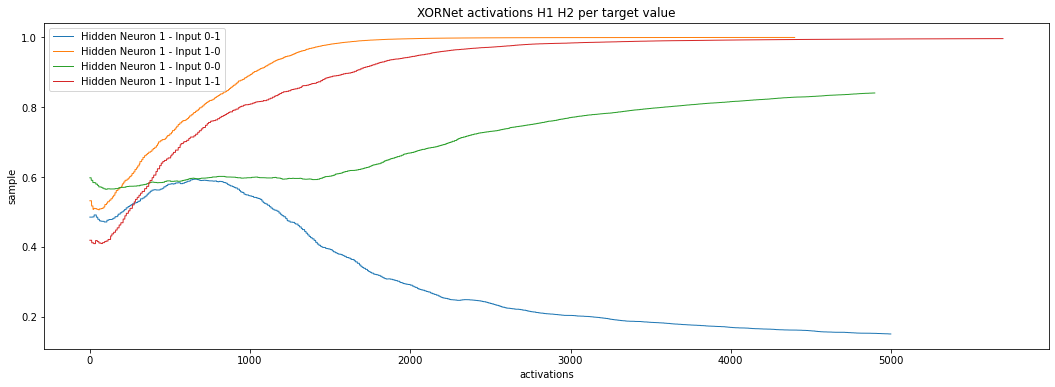

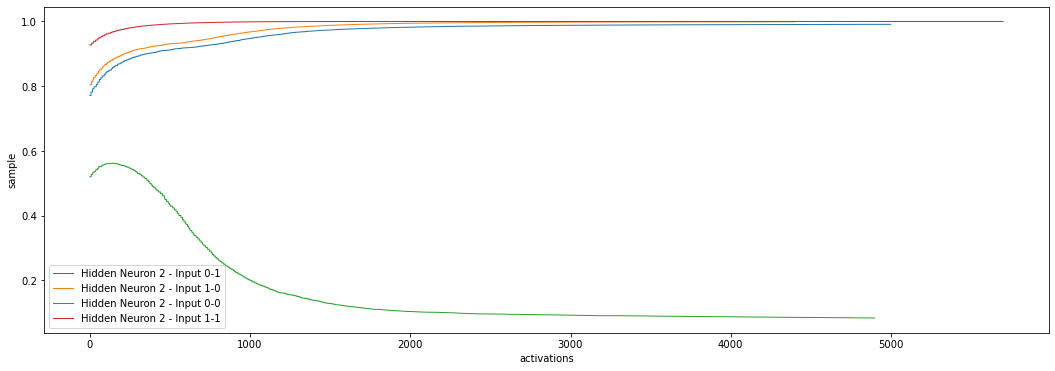

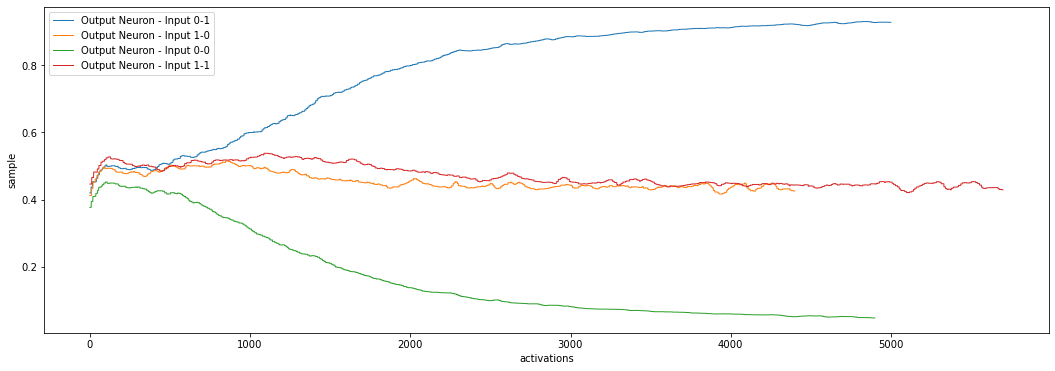

In [ ]:
fig, axs= plt.subplots(1, 1, figsize=(18, 6))  
plt.title('XORNet activations H1 H2 per target value')

neurons = activation_collector.neurons

t0_idx = [i for i in range(len(activation_collector.targets)) if activation_collector.targets[i] == 0]
t1_idx = [i for i in range(len(activation_collector.targets)) if activation_collector.targets[i] == 1]
i01_idx = [i for i in range(len(activation_collector.targets)) if activation_collector.neurons['0-0'][i] == 0 and activation_collector.neurons['0-1'][i] == 1 ]
i10_idx = [i for i in range(len(activation_collector.targets)) if activation_collector.neurons['0-0'][i] == 1 and activation_collector.neurons['0-1'][i] == 0 ]
i00_idx = [i for i in range(len(activation_collector.targets)) if activation_collector.neurons['0-0'][i] == 0 and activation_collector.neurons['0-1'][i] == 0 ]
i11_idx = [i for i in range(len(activation_collector.targets)) if activation_collector.neurons['0-0'][i] == 1 and activation_collector.neurons['0-1'][i] == 1 ]

axs.plot([ neurons['1-0'][i] for i in i01_idx ], linewidth=1, label='Hidden Neuron 1 - Input 0-1')
axs.plot([ neurons['1-0'][i] for i in i10_idx ], linewidth=1, label='Hidden Neuron 1 - Input 1-0')
axs.plot([ neurons['1-0'][i] for i in i00_idx ], linewidth=1, label='Hidden Neuron 1 - Input 0-0')
axs.plot([ neurons['1-0'][i] for i in i11_idx ], linewidth=1, label='Hidden Neuron 1 - Input 1-1')
# axs.plot([ activation_collector.neurons['1-0'][i] for i in t1_idx ],  linewidth=1, label='Hidden Neuron 1 - Target 1')

axs.set_xlabel('activations')
axs.set_ylabel('sample')
plt.legend()
plt.show()

fig, axs= plt.subplots(1, 1, figsize=(18, 6))  
axs.plot([ neurons['1-1'][i] for i in i01_idx ], linewidth=1, label='Hidden Neuron 2 - Input 0-1')
axs.plot([ neurons['1-1'][i] for i in i10_idx ], linewidth=1, label='Hidden Neuron 2 - Input 1-0')
axs.plot([ neurons['1-1'][i] for i in i00_idx ], linewidth=1, label='Hidden Neuron 2 - Input 0-0')
axs.plot([ neurons['1-1'][i] for i in i11_idx ], linewidth=1, label='Hidden Neuron 2 - Input 1-1')

axs.set_xlabel('activations')
axs.set_ylabel('sample')
plt.legend()
plt.show()

fig, axs= plt.subplots(1, 1, figsize=(18, 6))  
axs.plot([ neurons['2-0'][i] for i in i01_idx ], linewidth=1, label='Output Neuron - Input 0-1')
axs.plot([ neurons['2-0'][i] for i in i10_idx ], linewidth=1, label='Output Neuron - Input 1-0')
axs.plot([ neurons['2-0'][i] for i in i00_idx ], linewidth=1, label='Output Neuron - Input 0-0')
axs.plot([ neurons['2-0'][i] for i in i11_idx ], linewidth=1, label='Output Neuron - Input 1-1')

axs.set_xlabel('activations')
axs.set_ylabel('sample')
plt.legend()
plt.show()

## Print TE

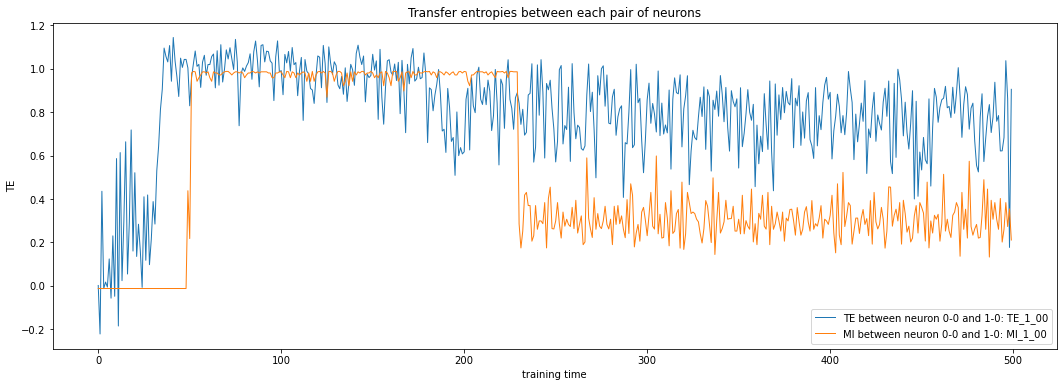

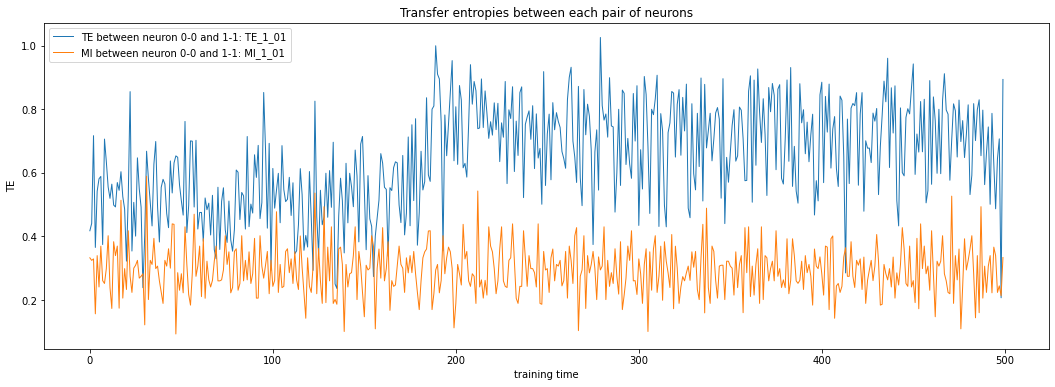

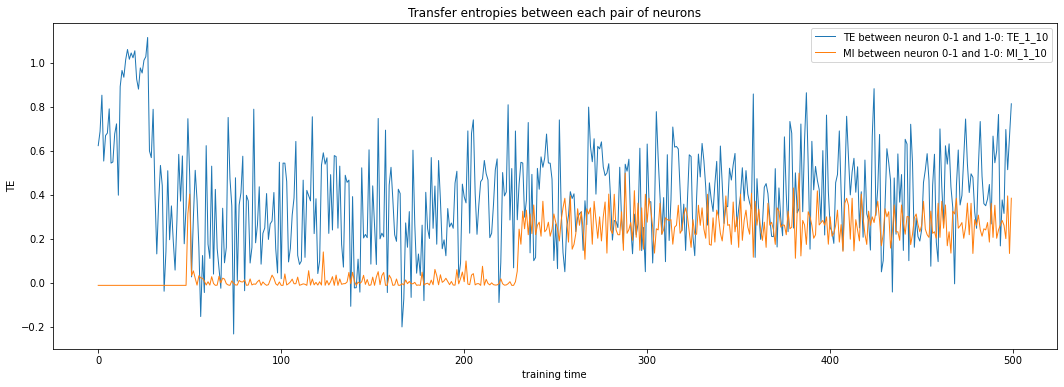

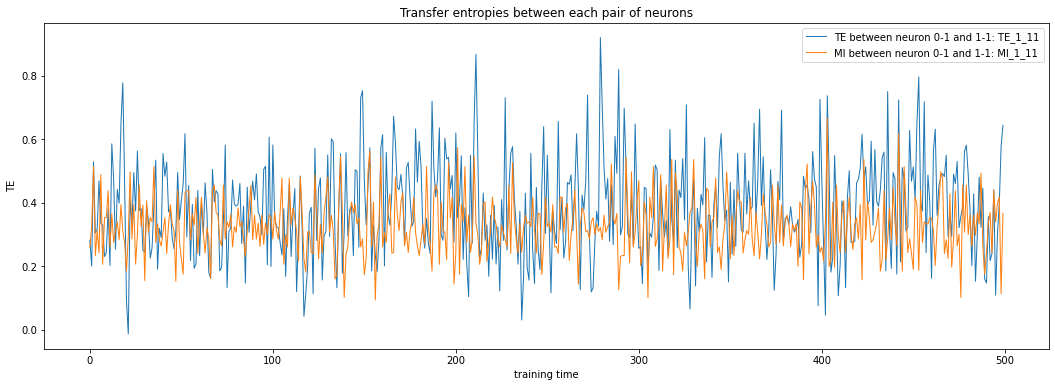

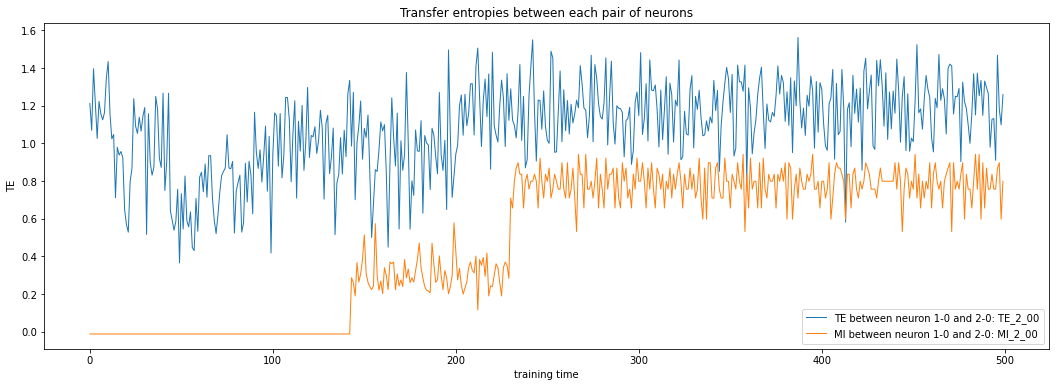

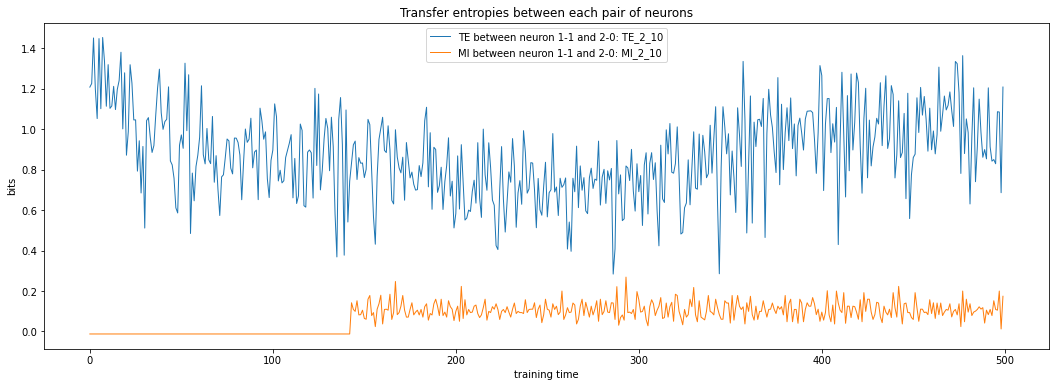

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
normalizl = lambda lst: scaler.fit_transform(np.array(lst).reshape(len(lst), 1))

fig, axs= plt.subplots(1, 1, figsize=(18, 6))  
plt.title('Transfer entropies between each pair of neurons')
axs.set_xlabel('training time')
axs.set_ylabel('TE')



history = pd.DataFrame(teCalc.tekHistory)/np.log(2)  # kraskov te in bits
historymi = teCalc.miHistory

axs.plot(history['0-0-1-0'], linewidth=1, label='TE between neuron 0-0 and 1-0: TE_1_00')
axs.plot(historymi['0-0-1-0'], linewidth=1, label='MI between neuron 0-0 and 1-0: MI_1_00')

plt.legend()
plt.show()

fig, axs= plt.subplots(1, 1, figsize=(18, 6))  
plt.title('Transfer entropies between each pair of neurons')
axs.set_xlabel('training time')
axs.set_ylabel('TE')

axs.plot(history['0-0-1-1'], linewidth=1, label='TE between neuron 0-0 and 1-1: TE_1_01')
axs.plot(historymi['0-0-1-1'], linewidth=1, label='MI between neuron 0-0 and 1-1: MI_1_01')

plt.legend()
plt.show()

fig, axs= plt.subplots(1, 1, figsize=(18, 6))  
plt.title('Transfer entropies between each pair of neurons')
axs.set_xlabel('training time')
axs.set_ylabel('TE')

axs.plot(history['0-1-1-0'], linewidth=1, label='TE between neuron 0-1 and 1-0: TE_1_10')
axs.plot(historymi['0-1-1-0'], linewidth=1, label='MI between neuron 0-1 and 1-0: MI_1_10')

plt.legend()
plt.show()

fig, axs= plt.subplots(1, 1, figsize=(18, 6))  
plt.title('Transfer entropies between each pair of neurons')
axs.set_xlabel('training time')
axs.set_ylabel('TE')

axs.plot(history['0-1-1-1'], linewidth=1, label='TE between neuron 0-1 and 1-1: TE_1_11')
axs.plot(historymi['0-1-1-1'], linewidth=1, label='MI between neuron 0-1 and 1-1: MI_1_11')

plt.legend()
plt.show()


fig, axs= plt.subplots(1, 1, figsize=(18, 6))  
plt.title('Transfer entropies between each pair of neurons')
axs.set_xlabel('training time')
axs.set_ylabel('TE')

axs.plot(history['1-0-2-0'], linewidth=1, label='TE between neuron 1-0 and 2-0: TE_2_00')
axs.plot(historymi['1-0-2-0'], linewidth=1, label='MI between neuron 1-0 and 2-0: MI_2_00')

plt.legend()
plt.show()

fig, axs= plt.subplots(1, 1, figsize=(18, 6))  
plt.title('Transfer entropies between each pair of neurons')
axs.set_xlabel('training time')
axs.set_ylabel('bits')

axs.plot(history['1-1-2-0'], linewidth=1, label='TE between neuron 1-1 and 2-0: TE_2_10')
axs.plot(historymi['1-1-2-0'], linewidth=1, label='MI between neuron 1-1 and 2-0: MI_2_10')
#axs.plot(normalizl(loggers['train'].all_minibatches_accuracies), label='Minibatch Train accuracy')


plt.legend()
plt.show()

In [ ]:
history = pd.DataFrame(teCalc.tekHistory)
history2 = pd.DataFrame(teCalc.tekHistory) * 2
history.head()

,0-0-1-0,0-0-1-1,0-1-1-0,0-1-1-1,1-0-2-0,1-1-2-0
0,0.000985,0.289609,0.431388,0.194811,0.839811,0.837719
1,-0.153834,0.305666,0.476404,0.138680,0.741166,0.849977
2,0.301817,0.496803,0.590289,0.366444,0.968016,1.006192
3,-0.009019,0.253261,0.382833,0.210859,0.843097,0.830723
4,0.011944,0.375649,0.463155,0.219513,0.711348,0.729905


In [ ]:
history2.head()

,0-0-1-0,0-0-1-1,0-1-1-0,0-1-1-1,1-0-2-0,1-1-2-0
0,0.001970,0.579218,0.862775,0.389622,1.679622,1.675438
1,-0.307669,0.611332,0.952809,0.277360,1.482331,1.699953
2,0.603635,0.993606,1.180578,0.732889,1.936032,2.012383
3,-0.018039,0.506521,0.765666,0.421719,1.686194,1.661446
4,0.023887,0.751298,0.926310,0.439026,1.422696,1.459810


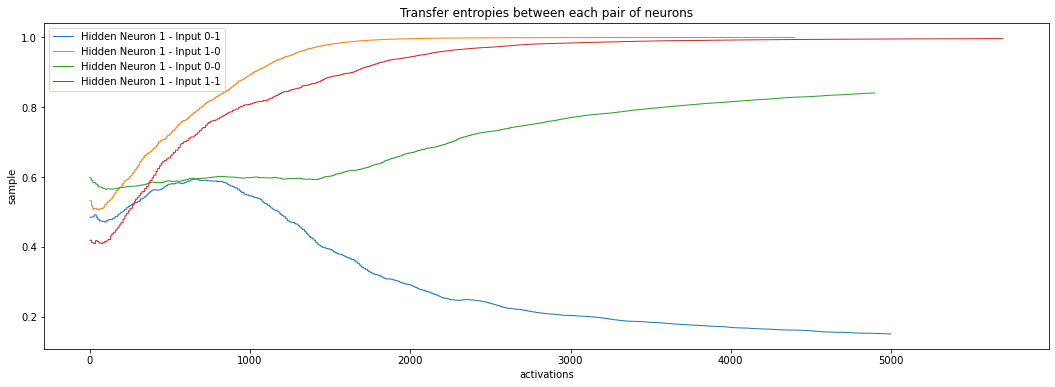

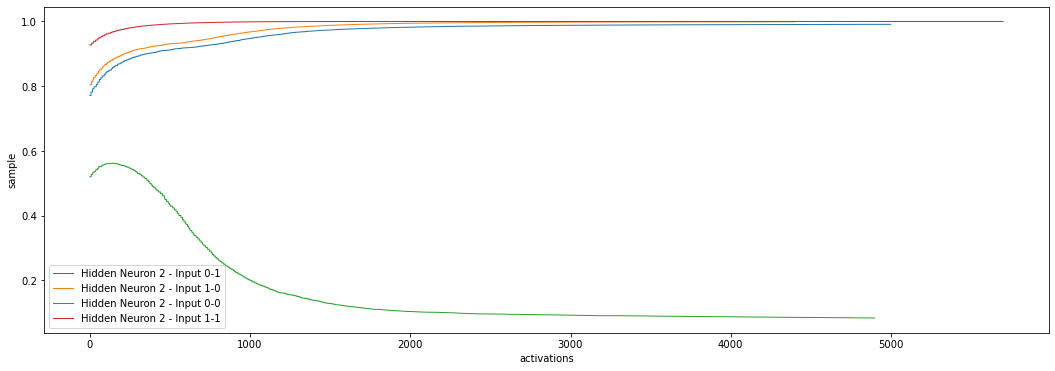

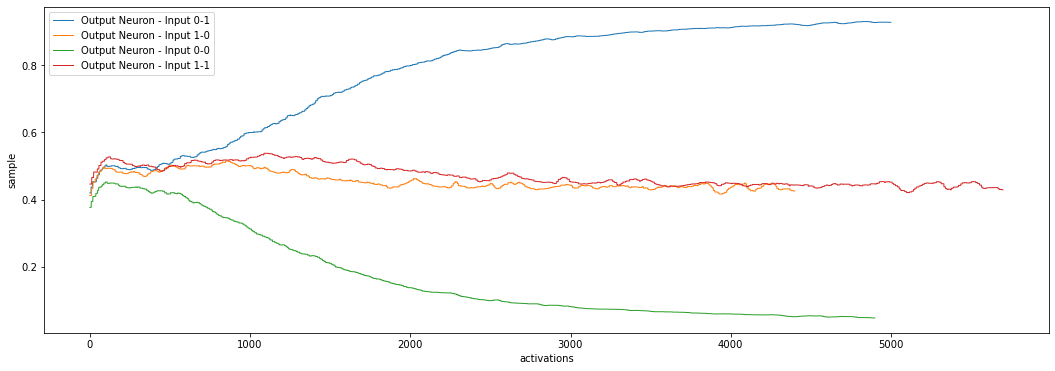

In [ ]:
fig, axs= plt.subplots(1, 1, figsize=(18, 6))  
plt.title('Transfer entropies between each pair of neurons')

t0_idx = [i for i in range(len(activation_collector.targets)) if activation_collector.targets[i] == 0]
t1_idx = [i for i in range(len(activation_collector.targets)) if activation_collector.targets[i] == 1]
i01_idx = [i for i in range(len(activation_collector.targets)) if activation_collector.neurons['0-0'][i] == 0 and activation_collector.neurons['0-1'][i] == 1 ]
i10_idx = [i for i in range(len(activation_collector.targets)) if activation_collector.neurons['0-0'][i] == 1 and activation_collector.neurons['0-1'][i] == 0 ]
i00_idx = [i for i in range(len(activation_collector.targets)) if activation_collector.neurons['0-0'][i] == 0 and activation_collector.neurons['0-1'][i] == 0 ]
i11_idx = [i for i in range(len(activation_collector.targets)) if activation_collector.neurons['0-0'][i] == 1 and activation_collector.neurons['0-1'][i] == 1 ]

axs.plot([ activation_collector.neurons['1-0'][i] for i in i01_idx ], linewidth=1, label='Hidden Neuron 1 - Input 0-1')
axs.plot([ activation_collector.neurons['1-0'][i] for i in i10_idx ], linewidth=1, label='Hidden Neuron 1 - Input 1-0')
axs.plot([ activation_collector.neurons['1-0'][i] for i in i00_idx ], linewidth=1, label='Hidden Neuron 1 - Input 0-0')
axs.plot([ activation_collector.neurons['1-0'][i] for i in i11_idx ], linewidth=1, label='Hidden Neuron 1 - Input 1-1')
# axs.plot([ activation_collector.neurons['1-0'][i] for i in t1_idx ],  linewidth=1, label='Hidden Neuron 1 - Target 1')

axs.set_xlabel('activations')
axs.set_ylabel('sample')
plt.legend()
plt.show()

fig, axs= plt.subplots(1, 1, figsize=(18, 6))  
axs.plot([ activation_collector.neurons['1-1'][i] for i in i01_idx ], linewidth=1, label='Hidden Neuron 2 - Input 0-1')
axs.plot([ activation_collector.neurons['1-1'][i] for i in i10_idx ], linewidth=1, label='Hidden Neuron 2 - Input 1-0')
axs.plot([ activation_collector.neurons['1-1'][i] for i in i00_idx ], linewidth=1, label='Hidden Neuron 2 - Input 0-0')
axs.plot([ activation_collector.neurons['1-1'][i] for i in i11_idx ], linewidth=1, label='Hidden Neuron 2 - Input 1-1')

axs.set_xlabel('activations')
axs.set_ylabel('sample')
plt.legend()
plt.show()

fig, axs= plt.subplots(1, 1, figsize=(18, 6))  
axs.plot([ activation_collector.neurons['2-0'][i] for i in i01_idx ], linewidth=1, label='Output Neuron - Input 0-1')
axs.plot([ activation_collector.neurons['2-0'][i] for i in i10_idx ], linewidth=1, label='Output Neuron - Input 1-0')
axs.plot([ activation_collector.neurons['2-0'][i] for i in i00_idx ], linewidth=1, label='Output Neuron - Input 0-0')
axs.plot([ activation_collector.neurons['2-0'][i] for i in i11_idx ], linewidth=1, label='Output Neuron - Input 1-1')

axs.set_xlabel('activations')
axs.set_ylabel('sample')
plt.legend()
plt.show()

Text(0, 0.5, 'sample')

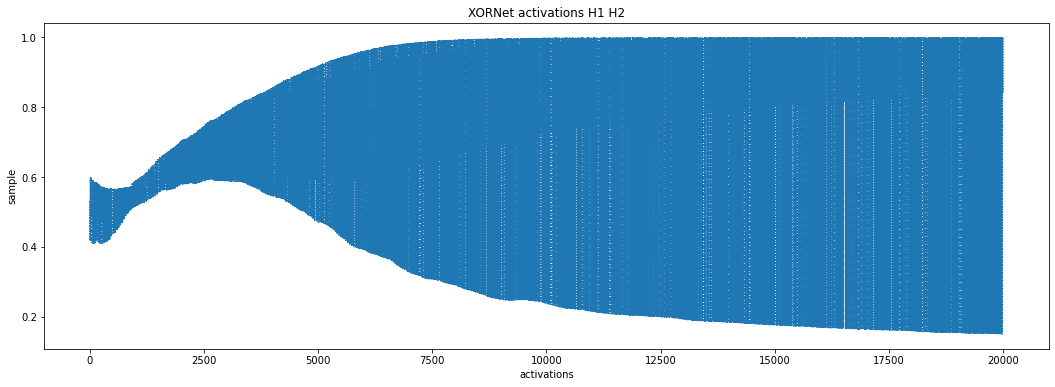

In [ ]:
fig, axs= plt.subplots(1, 1, figsize=(18, 6))  
plt.title('XORNet activations H1 H2')


axs.plot(activation_collector.neurons['1-0'], linestyle=":", linewidth=1, label='Hidden Neuron 1')

axs.set_xlabel('activations')
axs.set_ylabel('sample')

In [ ]:
x_in = torch.tensor([[1.0, 1.0]])

In [ ]:
model(x_in)

tensor([[0.5772]], grad_fn=<SigmoidBackward>)

In [ ]:
model.activations

[tensor([[1., 1.]]),
 tensor([[0.2836, 0.1670]], grad_fn=<SigmoidBackward>),
 tensor([[0.5772]], grad_fn=<SigmoidBackward>)]

In [ ]:
model.fc1.weight, model.fc1.bias

(Parameter containing:
 tensor([[-0.9002, -0.0623],
         [ 0.4685, -1.4092]], requires_grad=True),
 Parameter containing:
 tensor([ 0.0357, -0.6662], requires_grad=True))

In [ ]:
model.fc2.weight, model.fc2.bias

(Parameter containing:
 tensor([[ 0.5312, -1.0161]], requires_grad=True),
 Parameter containing:
 tensor([0.3305], requires_grad=True))

In [ ]:
for param in model.parameters():
    print('------------------------------------------')
    print(param)
    print(type(param))
    print(type(param.data), param.size())
    print(param.data)
    print(param.name)

------------------------------------------
Parameter containing:
tensor([[-0.9002, -0.0623],
        [ 0.4685, -1.4092]], requires_grad=True)
<class 'torch.nn.parameter.Parameter'>
<class 'torch.Tensor'> torch.Size([2, 2])
tensor([[-0.9002, -0.0623],
        [ 0.4685, -1.4092]])
None
------------------------------------------
Parameter containing:
tensor([ 0.0357, -0.6662], requires_grad=True)
<class 'torch.nn.parameter.Parameter'>
<class 'torch.Tensor'> torch.Size([2])
tensor([ 0.0357, -0.6662])
None
------------------------------------------
Parameter containing:
tensor([[ 0.5312, -1.0161]], requires_grad=True)
<class 'torch.nn.parameter.Parameter'>
<class 'torch.Tensor'> torch.Size([1, 2])
tensor([[ 0.5312, -1.0161]])
None
------------------------------------------
Parameter containing:
tensor([0.3305], requires_grad=True)
<class 'torch.nn.parameter.Parameter'>
<class 'torch.Tensor'> torch.Size([1])
tensor([0.3305])
None


In [ ]:
for name, parameter in model.named_parameters():
    if 'weight' in name:
        print(name, parameter)
        print(parameter.size()[1])

fc1.weight Parameter containing:
tensor([[-0.9002, -0.0623],
        [ 0.4685, -1.4092]], requires_grad=True)
2
fc2.weight Parameter containing:
tensor([[ 0.5312, -1.0161]], requires_grad=True)
2


# optimizer

